## Initialisation

In [ ]:
# Essential libraries
import pandas as pd
import numpy as np
import itertools

# Machine Learning
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense 
from keras import applications 
from keras.utils.np_utils import to_categorical

# Visualisation
%matplotlib inline
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import math 
import datetime
import time

## Preprocessing

In [ ]:
# ratio('vehicle_classification', output="split-dataset", seed=1337, ratio=(.8,0, .2)) # default values

# delete the extra empty validation folder
# dir_path = 'split-dataset/val/'

# try:
#     rmtree(dir_path)
# except OSError as e:
#     print("Error: %s : %s" % (dir_path, e.strerror))]

In [ ]:
#Default dimensions we found online
img_width, img_height = 224, 224 
 
top_model_weights_path = 'saved-models/bottleneck_fc_model.h5'# loading up our datasets
train_data_dir = 'split-dataset/train' 
test_data_dir = 'split-dataset/test'
 
# number of epochs to train top model 
epochs = 7 #this has been changed after multiple model run 
# batch size used by flow_from_directory and predict_generator 
batch_size = 50 

#Loading vgc16 model
vgg16 = applications.VGG16(include_top=False, weights='imagenet')
datagen = ImageDataGenerator(rescale=1. / 255) 

In [ ]:
# Only needs to run once to create the bottleneck .npy files
 
# generator = datagen.flow_from_directory( 
#     train_data_dir, 
#     target_size=(img_width, img_height), 
#     batch_size=batch_size, 
#     class_mode=None, 
#     shuffle=False) 
 
# nb_train_samples = len(generator.filenames) 
# num_classes = len(generator.class_indices) 
 
# predict_size_train = int(math.ceil(nb_train_samples / batch_size)) 
 
# bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train) 
 
# np.save('bottleneck_features_train.npy', bottleneck_features_train)
# end= datetime.datetime.now()

In [5]:
#training data
generator_top = datagen.flow_from_directory( 
   train_data_dir, 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_train_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
# load the bottleneck features saved earlier 
train_data = np.load('bottleneck_features_train.npy') 
 
# get the class labels for the training data, in the original order 
train_labels = generator_top.classes 
 
# convert the training labels to categorical vectors 
train_labels = to_categorical(train_labels, num_classes=num_classes)



Found 21098 images belonging to 8 classes.


In [6]:
generator_test = datagen.flow_from_directory( 
   test_data_dir, 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 

nb_val_samples = len(generator_test.filenames) 
num_val_classes = len(generator_test.class_indices) 

test_data = np.load('bottleneck_features_train.npy') 
 
# get the class labels for the training data, in the original order 
test_labels = generator_top.classes 
 
# convert the training labels to categorical vectors 
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 5280 images belonging to 8 classes.


In [ ]:
start = datetime.datetime.now()
model = Sequential() 
model.add(Flatten(input_shape=train_data.shape[1:])) 
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.5)) 
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
   optimizer=optimizers.RMSprop(lr=1e-4),
   metrics=['acc'])

history = model.fit(train_data, train_labels, 
   epochs=15,
   batch_size=batch_size, validation_data=(test_data, test_labels))

model.save_weights(top_model_weights_path)


In [14]:
model.load_weights("saved-models/bottleneck_fc_model.h5")


In [15]:
(test_loss, test_accuracy) = model.evaluate(test_data, test_labels, batch_size=batch_size, verbose=1)
(train_loss, train_accuracy) = model.evaluate(train_data, train_labels, batch_size=batch_size, verbose=1)

422/422 [==============================] - 9s 22ms/step - loss: 0.2773 - acc: 0.9004


In [16]:
print("Train Accuracy: {:.2f}%".format(train_accuracy * 100))
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))
print()
print("Train Loss: {:.2f}%".format(train_loss * 100))
print("Test Loss: {:.2f}%".format(test_loss * 100))

Train Accuracy: 90.04%
Test Accuracy: 90.04%

Train Loss: 27.73%
Test Loss: 27.73%


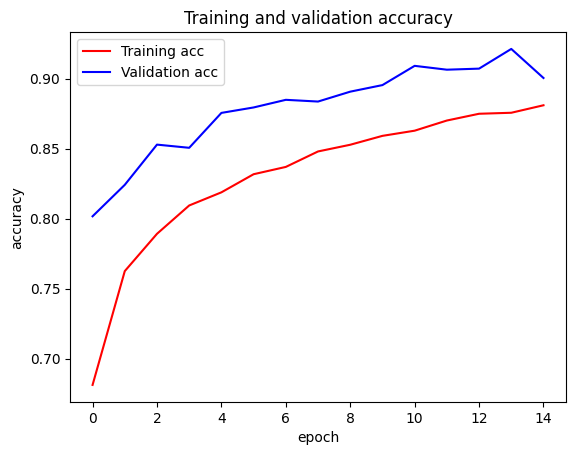

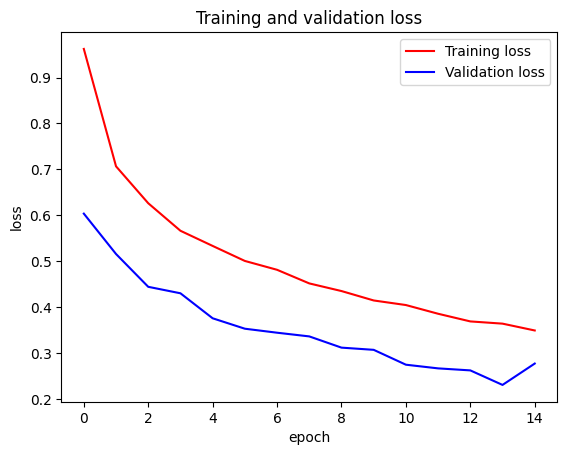

In [17]:
#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

In [61]:
def read_image(file_path):
   image = load_img(file_path, target_size=(224, 224)) 
   image = img_to_array(image) 
   image = np.expand_dims(image, axis=0)
   image /= 255. 
   return image

def test_single_image(path):
  percent_list = []

  vechiles = ['Bicycle', 'Bus', 'Car', 'Motorcycle', 'NonVehicles', 'Taxi', 'Truck', 'Van']
  images = read_image(path)
  time.sleep(.5)
  bt_prediction = vgg16.predict(images) 
  preds = model.predict(bt_prediction)
  for idx, vechile, x in zip(range(0,8), vechiles , preds[0]):
    percent_list.append(round(x*100,2))
  return percent_list




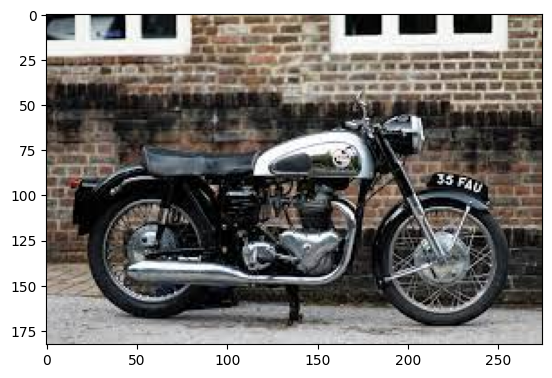

1/1 [==============================] - 0s 33ms/step
Prediction: Motorcycle


In [62]:
# Plot image from directory
path = 'test-images/6.jpg'
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread(path)
imgplot = plt.imshow(img)
plt.show()

t = test_single_image(path)

vechiles = ['Bicycle', 'Bus', 'Car', 'Motorcycle', 'NonVehicles', 'Taxi', 'Truck', 'Van']

# Create a dataframe of the results
d = {'Vechicles': vechiles, 'Percent Chance': t}
df = pd.DataFrame(data=d)

print(f"Prediction: {(df.loc[df['Percent Chance'].idxmax()])['Vechicles']}")


In [63]:
df

,Vechicles,Percent Chance
0,Bicycle,0.07
1,Bus,0.00
2,Car,0.00
3,Motorcycle,99.93
4,NonVehicles,0.00
5,Taxi,0.00
6,Truck,0.00
7,Van,0.00
